# Importing packages and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# The dataset we will be working with consists of 16 folders each containing 8 separate .csv files. 
# The data is available at
# https://physionet.org/content/big-ideas-glycemic-wearable/1.1.2/
# In order to work with the data, we define some helper functions

# Import helper functions:
from data_processing.cgm_data import CGMData
from data_processing.cgm_data_helper import plot_series_with_food, plot_series_with_diff
from data_processing.derived_datasets import max_glucose_dataset,max_glucose_between_meals_dataset

In [3]:
data = CGMData()

Patient 2 HbA1C: 5.6
Data available from 2020-02-21 11:08:36 to 2020-02-29 09:38:24


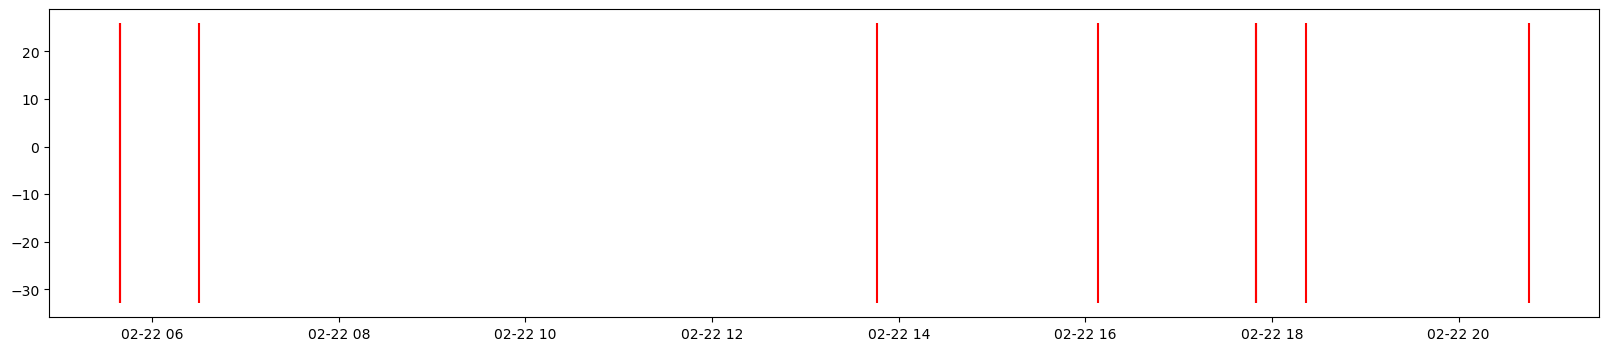

In [9]:
# Patient 2's glucose data with red lines indicating time of logged food intake
print('Patient 2 HbA1C:', data[2].hba1c)
print('Data available from',data[2].glu.index.min(),'to',data[2].glu.index.max())

plot_series_with_diff(data[2].glu, data[2].food, '2020-02-22', '2020-02-22')

In [30]:
data[2].bvp[pd.Timestamp('2020-02-22'):pd.Timestamp('2020-02-22')+pd.Timedelta(days=1)]

,bvp
datetime,
2020-02-22 00:00:00.000000,7.96
2020-02-22 00:00:00.015625,7.09
2020-02-22 00:00:00.031250,6.19
2020-02-22 00:00:00.046875,5.13
2020-02-22 00:00:00.062500,3.86
...,...
2020-02-22 23:59:59.937500,-0.06
2020-02-22 23:59:59.953125,-2.74
2020-02-22 23:59:59.968750,-5.52


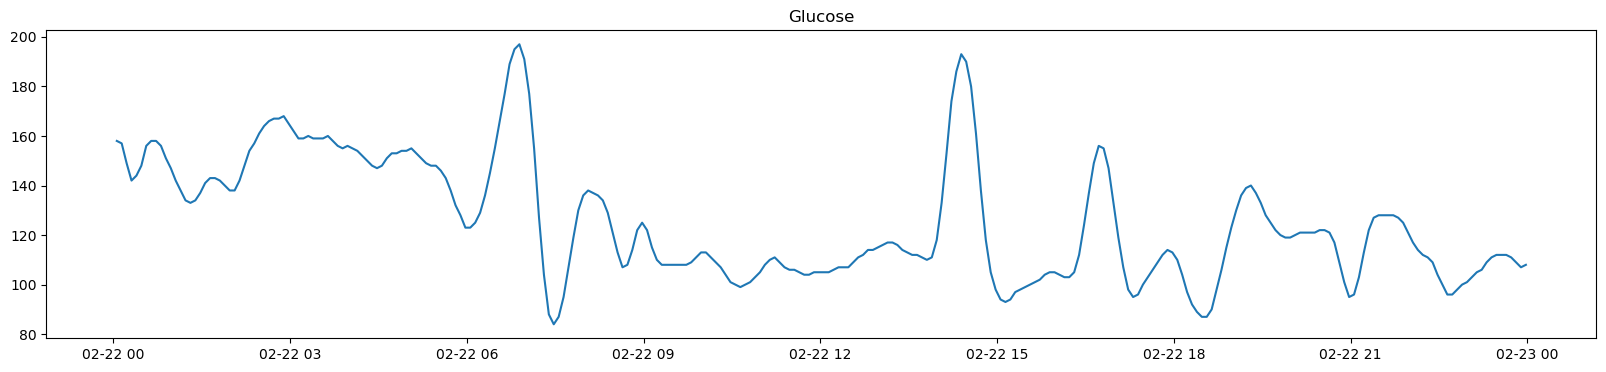

In [39]:
plt.figure(figsize=(20, 4))
plt.title('Glucose')
plt.plot(data[2].glu[pd.Timestamp('2020-02-22'):pd.Timestamp('2020-02-22')+pd.Timedelta(days=1)])
plt.show()

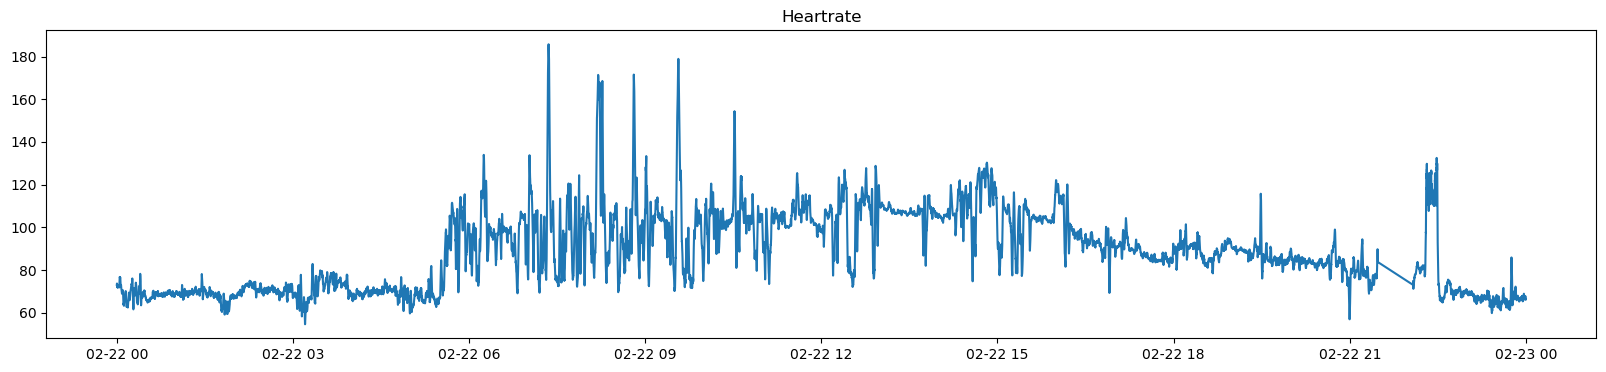

In [38]:
plt.figure(figsize=(20, 4))
plt.title('Heartrate')
plt.plot(data[2].hr[pd.Timestamp('2020-02-22'):pd.Timestamp('2020-02-22')+pd.Timedelta(days=1)])
plt.show()

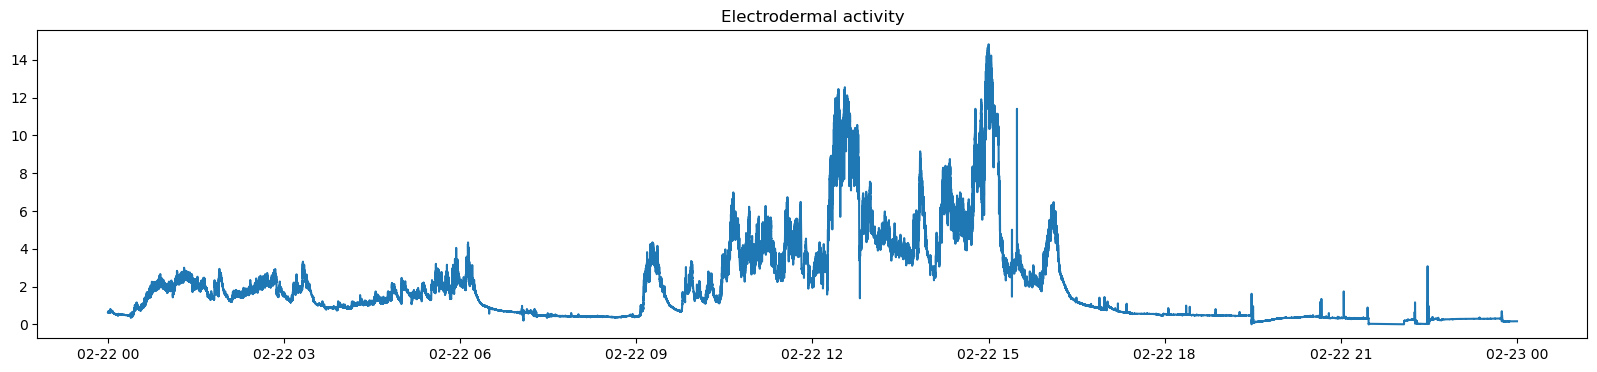

In [37]:
plt.figure(figsize=(20, 4))
plt.title('Electrodermal activity')
plt.plot(data[2].eda[pd.Timestamp('2020-02-22'):pd.Timestamp('2020-02-22')+pd.Timedelta(days=1)])
plt.show()

In [40]:
plt.plot(data[1].acc[(data[1].acc.index < '2020-02-14 08:00:00') & (data[1].acc.index > '2020-02-14 03:00:00')])

,ibi
datetime,
2020-02-21 09:19:34.345047,0.781286
2020-02-21 09:19:35.204462,0.859414
2020-02-21 09:19:35.985748,0.781286
2020-02-21 09:19:47.408145,0.781286
2020-02-21 09:19:48.205057,0.796911
...,...
2020-02-29 12:30:14.756546,0.515649
2020-02-29 12:32:02.683361,0.343766
2020-02-29 12:32:39.700681,0.546900


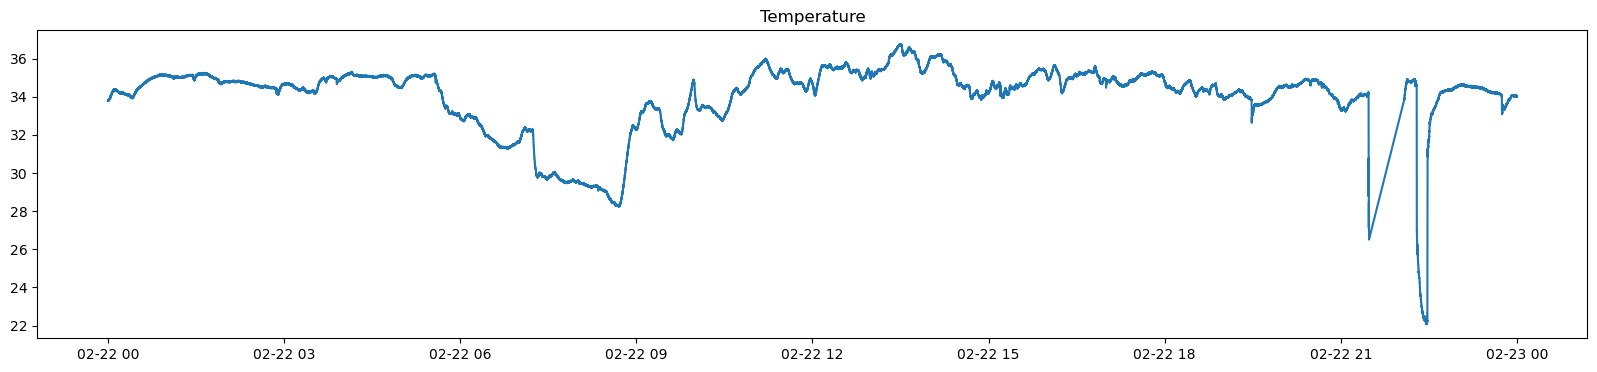

In [41]:
plt.figure(figsize=(20, 4))
plt.title('Temperature')
plt.plot(data[2].temp[pd.Timestamp('2020-02-22'):pd.Timestamp('2020-02-22')+pd.Timedelta(days=1)])
plt.show()

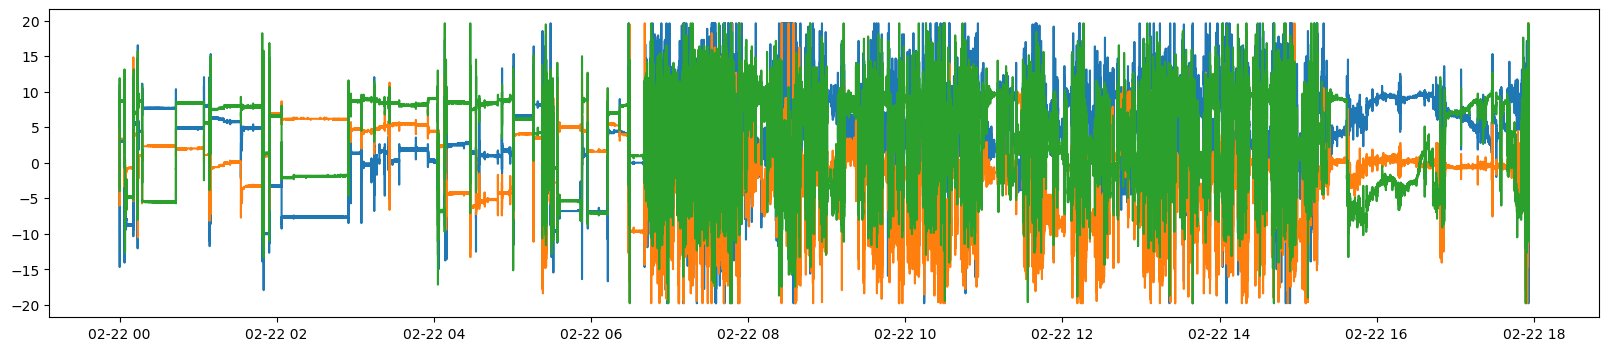

In [50]:
plt.figure(figsize=(20, 4))
#plt.axis([pd.Timestamp('2020-02-22'),pd.Timestamp('2020-02-22')+pd.Timedelta(days=1),-30, 30])
plt.plot(data[1].acc[(data[1].acc.index < pd.Timestamp('2020-02-22')+pd.Timedelta(days=1)) & (data[1].acc.index > pd.Timestamp('2020-02-22'))])

plt.show()

We would like to predict features of the glucose spike after a meal.

A basic version of this problem is a classification problem: which meals lead to a high bloodsugar event? To pursue this, we look at our available data for quantifying a meal as well as how to determine what counts as a high bloodsugar event.

## High bloodsugar events

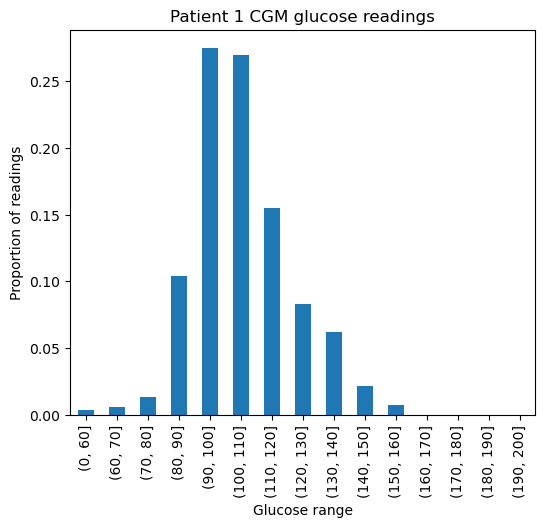

In [13]:
# Histogram of glucose readings for Patient 1
bins = pd.IntervalIndex.from_tuples([(0,60),(60,70),(70,80),(80,90),(90,100),(100,110),(110,120),(120,130),(130,140),(140,150),(150,160),(160,170),(170,180),(180,190),(190,200)])
pd.cut(data[1].glu['glucose'],bins).value_counts(normalize=True).sort_index().plot.bar(figsize=(6,5))
plt.title('Patient 1 CGM glucose readings')
plt.xlabel("Glucose range");
plt.ylabel("Proportion of readings");

plt.show()

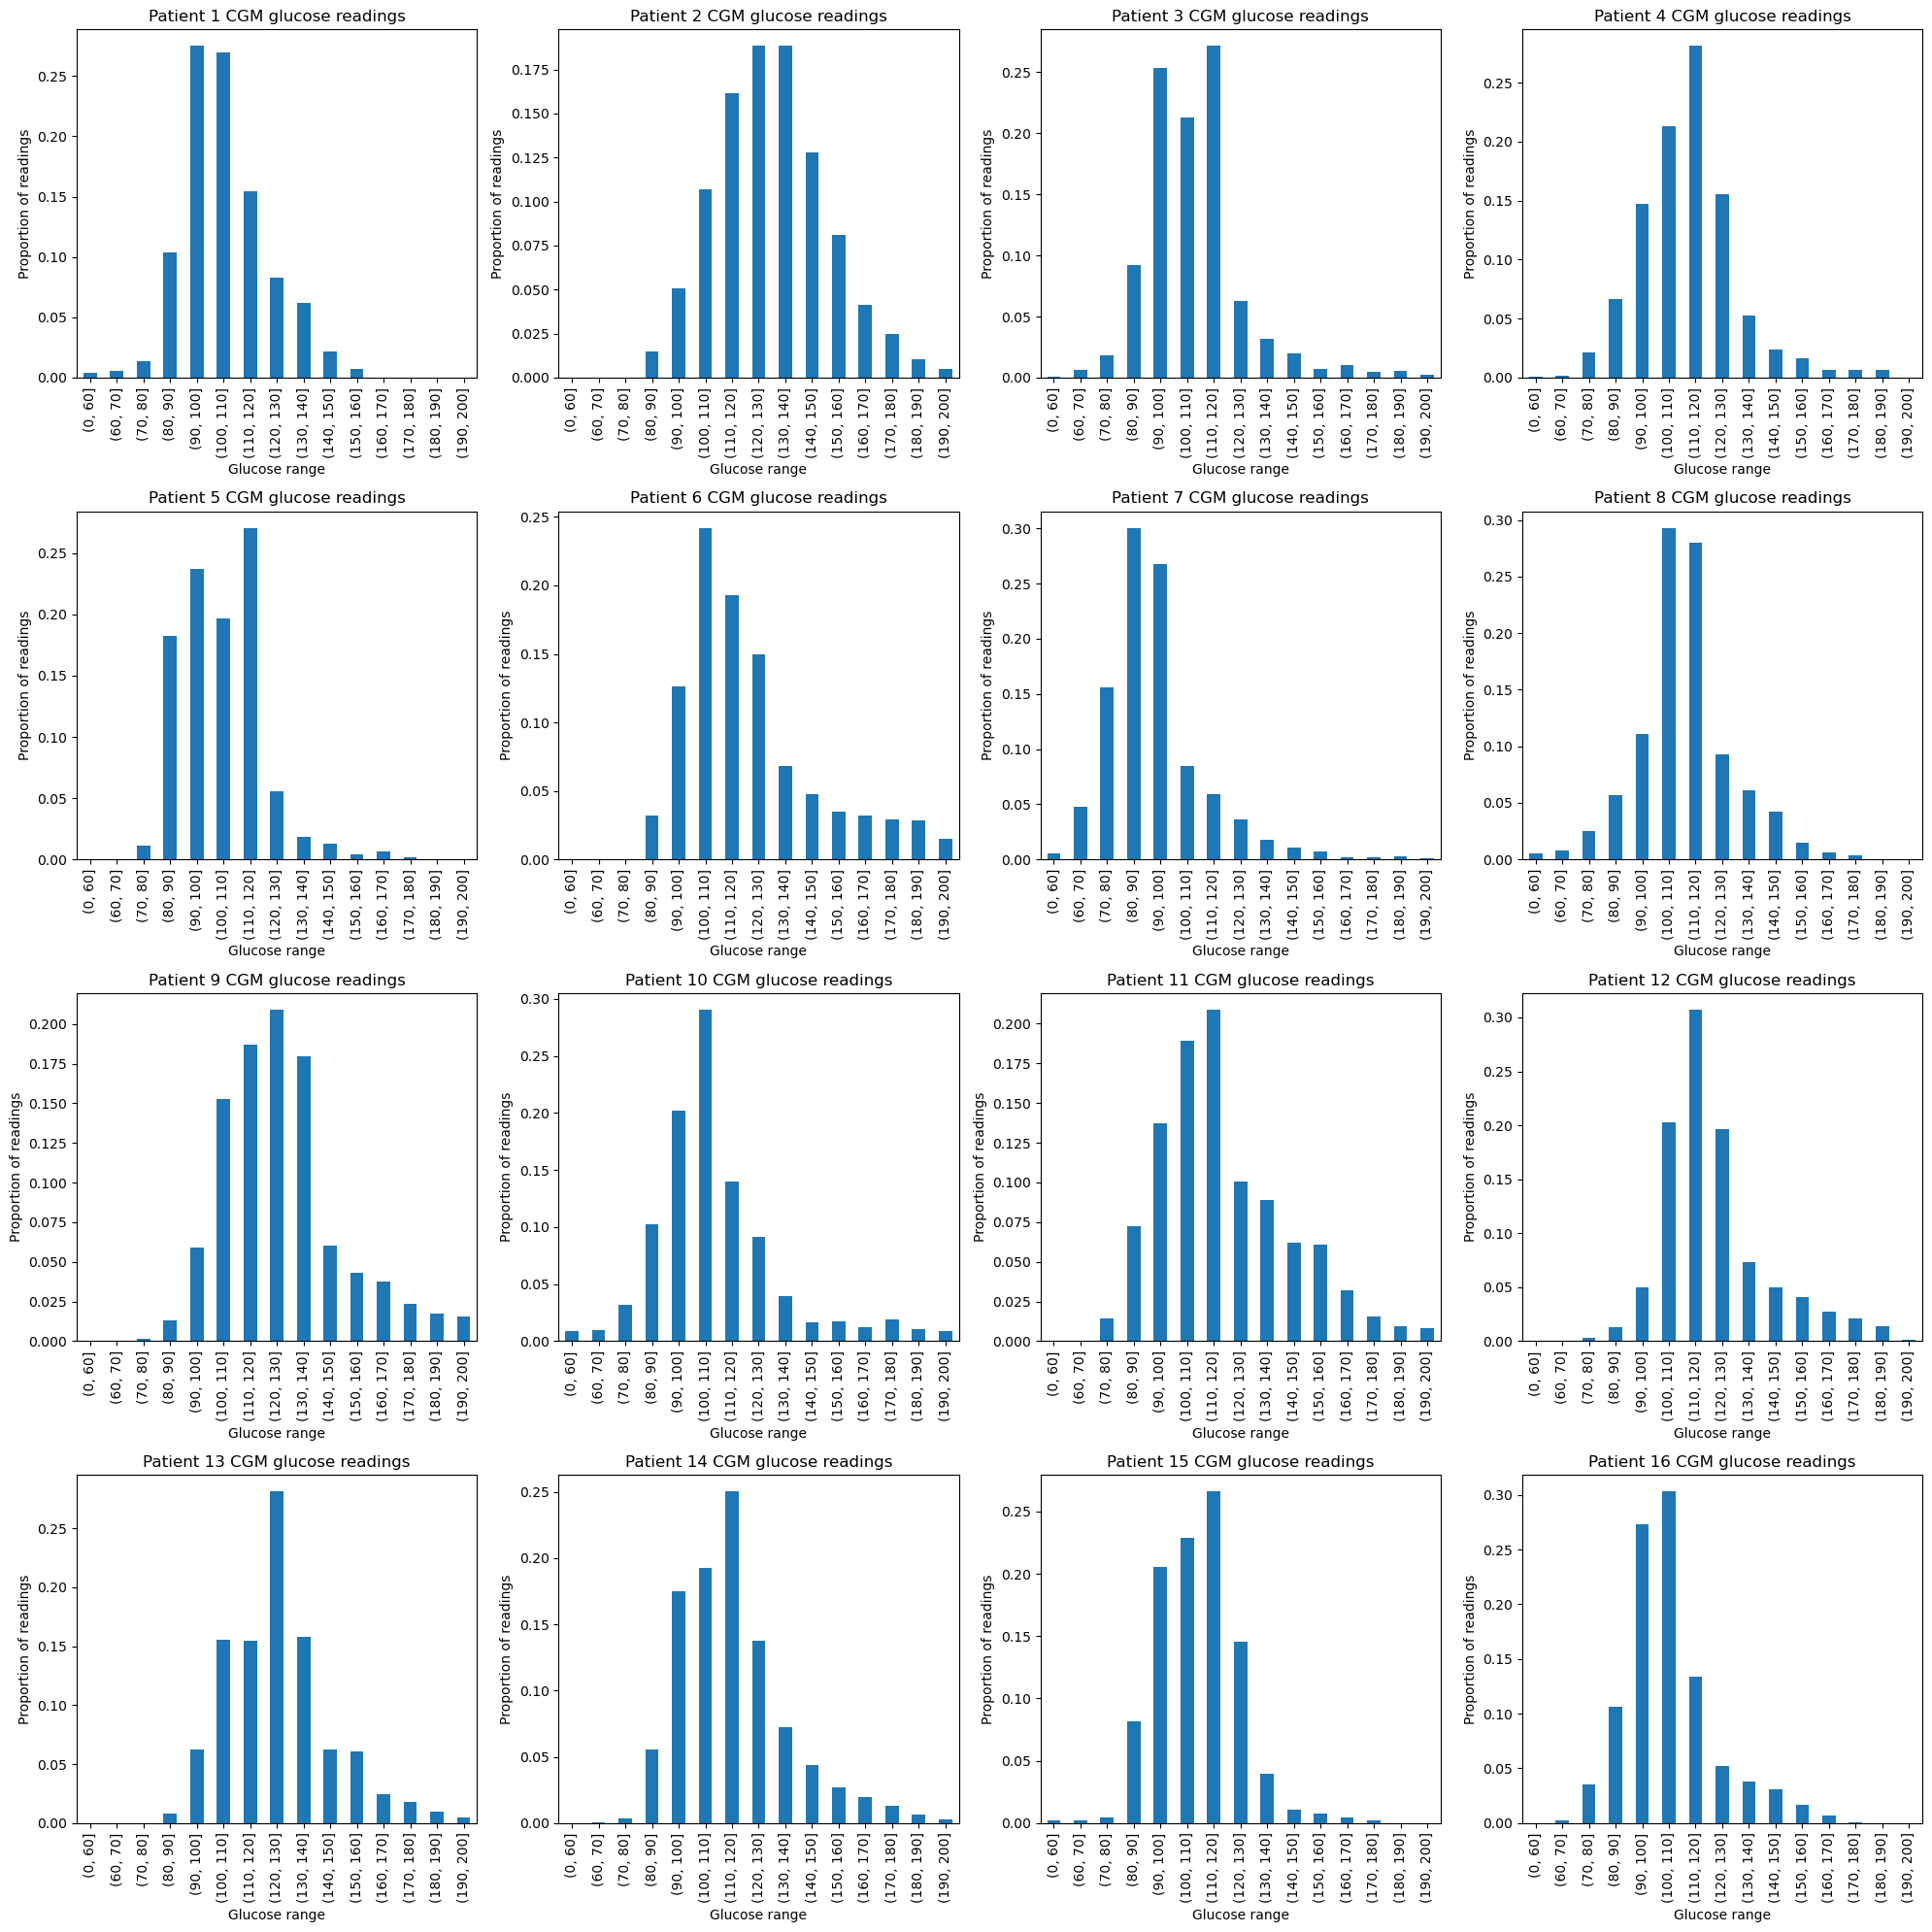

In [14]:
# Histograms for all 16 patients

# Create a figure with a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

# Loop through each patient and create a histogram in the respective subplot
for i in range(1, 17):
    ax = axes[i-1]
    patient_data = data[i].glu['glucose']
    pd.cut(patient_data, bins).value_counts(normalize=True).sort_index().plot.bar(ax=ax)
    ax.set_title(f'Patient {i} CGM glucose readings')
    ax.set_xlabel("Glucose range")
    ax.set_ylabel("Proportion of readings")

plt.tight_layout()
plt.show()

### Version 1: high bloodsugar set at a fixed level determined by each patient's bloodsugar data

Some patients have generally higher/lower bloodsugars than others, so what counts as a high bloodsugar should be patient-specific.

High bloodsugar for Patient 2 set at 167.0 (95th percentile)


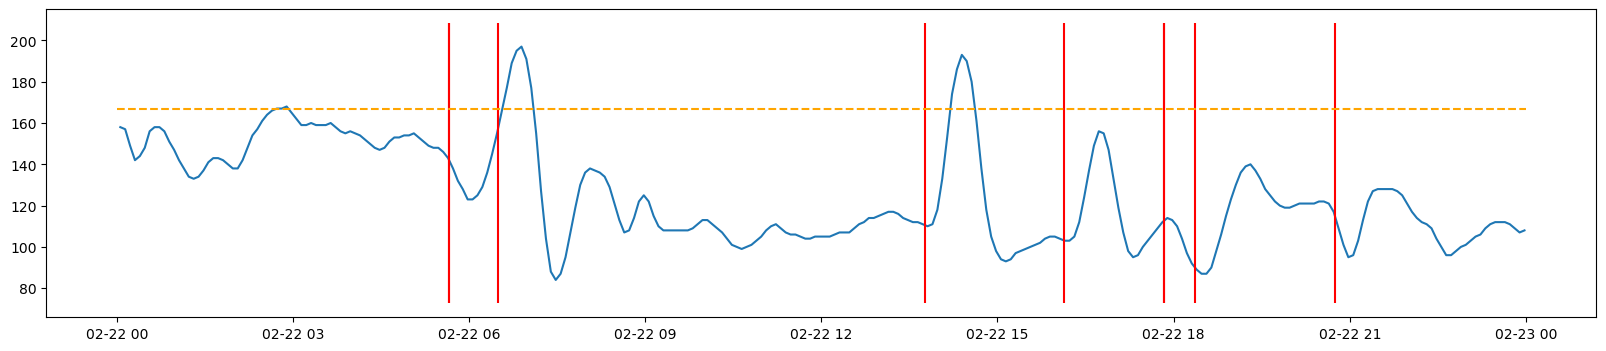

In [20]:
high_threshold = np.percentile(data[2].glu, 95)
print('High bloodsugar for Patient 2 set at', high_threshold, '(95th percentile)')

plot_series_with_food(data[2].glu, data[2].food, '2020-02-22', '2020-02-22')
plt.hlines(high_threshold, xmin=pd.Timestamp('2020-02-22'), xmax=pd.Timestamp('2020-02-22')+pd.Timedelta(days=1), colors="orange",linestyles="dashed")

plt.show()

Generally (but not always), high bloodsugars follow food intake of some sort. However, we miss a lot of glucose spikes this way: for example, if the glucose starts off low when eating, or on a downward trajectory, the resulting bloodsugar spike may not pass the high bloodsugar threshold.

### Version 2: Quantify bloodsugar spikes by difference data

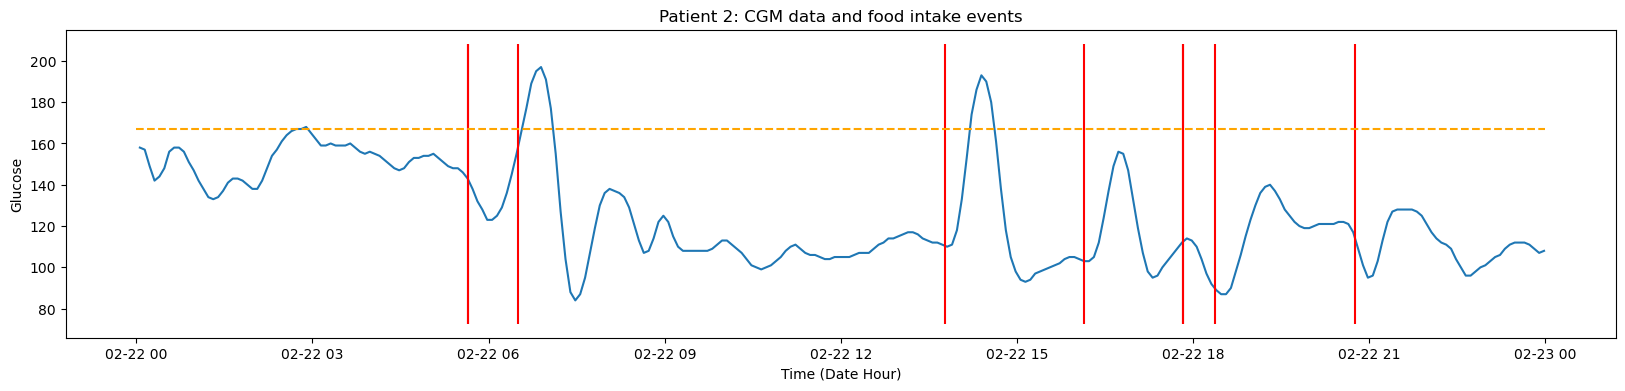

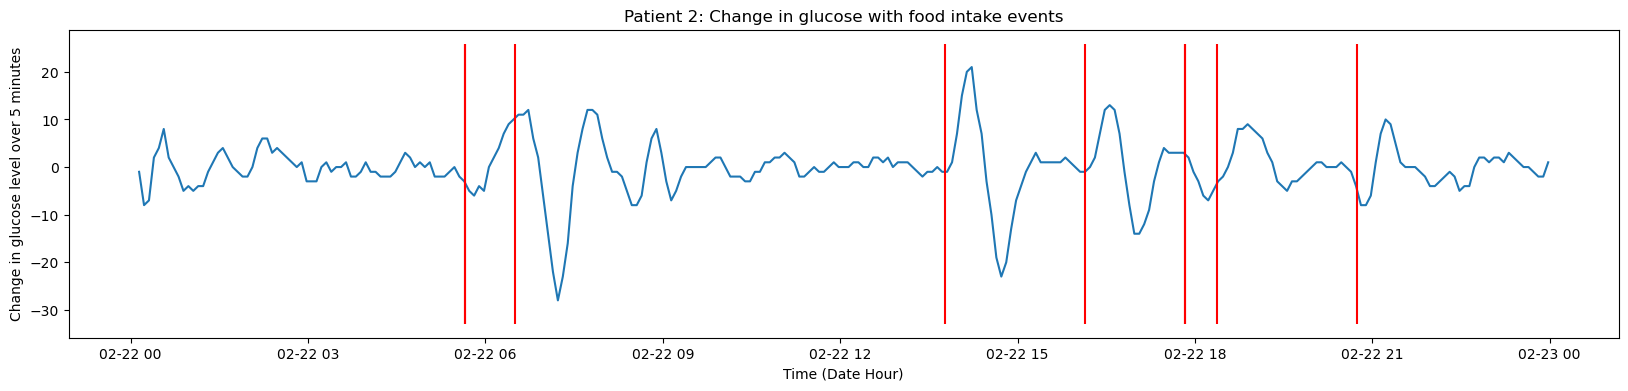

In [25]:
high_threshold = np.percentile(data[2].glu, 95)
plot_series_with_food(data[2].glu, data[2].food, '2020-02-22', '2020-02-22')
plt.hlines(high_threshold, xmin=pd.Timestamp('2020-02-22'), xmax=pd.Timestamp('2020-02-22')+pd.Timedelta(days=1), colors="orange",linestyles="dashed")
plt.title('Patient 2: CGM data and food intake events')
plt.xlabel('Time (Date Hour)')
plt.ylabel('Glucose')
plt.show()

plot_series_with_diff(data[2].glu, data[2].food, '2020-02-22', '2020-02-22')
plt.title('Patient 2: Change in glucose with food intake events')
plt.xlabel('Time (Date Hour)')
plt.ylabel('Change in glucose level over 5 minutes')
plt.show()